In [1]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

class IP_Solver_Capsule:
    def __init__(self, name="Integer_Programming_Model", sense='max'):
        """
        初始化整数规划求解器
        :param name: 模型名称
        :param sense: 'max' (最大化) 或 'min' (最小化)
        """
        self.name = name
        self.sense = pulp.LpMaximize if sense == 'max' else pulp.LpMinimize
        self.prob = pulp.LpProblem(name, self.sense)
        
        # 内部变量存储
        self.vars = {}           # 扁平化存储所有变量 {'x_0_1': var_obj}
        self.matrix_vars = {}    # 矩阵化存储 {'x': [[var...], ...]}
        self.constraints = {}
        self.objective_expr = None
        
        # 审计元数据 (用于 audit 阶段的逻辑检查)
        self.metadata = {
            'matrix_dims': {},   # 记录矩阵变量的维度 {'x': (rows, cols)}
            'big_m_count': 0,    # Big-M 约束计数
            'var_count': 0
        }
        
        self.is_solved = False
        self.status = None

    def add_variable_matrix(self, row_indices, col_indices, name="x", cat='Binary'):
        """
        [关键] 添加矩阵变量 x_ij (适用于指派问题、TSP、选址)
        :param row_indices: 行索引列表 (如 Workers, Cities)
        :param col_indices: 列索引列表 (如 Tasks, TimeSlots)
        :param cat: 'Binary'(0/1) 或 'Integer'
        """
        # 使用 PuLP 的字典变量功能
        var_dict = pulp.LpVariable.dicts(
            name, 
            (row_indices, col_indices), 
            cat=getattr(pulp, f"Lp{cat}"), 
            lowBound=0
        )
        
        # 注册到内部存储
        self.matrix_vars[name] = var_dict
        self.metadata['matrix_dims'][name] = (len(row_indices), len(col_indices))
        
        # 扁平化映射方便后续检索
        for r in row_indices:
            for c in col_indices:
                self.vars[f"{name}_{r}_{c}"] = var_dict[r][c]
                self.metadata['var_count'] += 1
                
        print(f"✅ 已注册矩阵变量 {name}_ij: 维度 {len(row_indices)}x{len(col_indices)} (类型: {cat})")
        return var_dict

    def add_big_M_constraint(self, bin_var, cont_var, M=100000, relation='<=', name="BigM_Link"):
        """
        [逻辑要求 6] 混合逻辑约束封装 (Big-M Method)
        场景：只有当 0/1 变量 bin_var=1 时，连续变量 cont_var 才有意义 (cont_var <= M * bin_var)
        """
        if relation == '<=':
            expr = (cont_var <= M * bin_var)
        elif relation == '>=':
            expr = (cont_var >= bin_var / M) # 仅示例，视具体逻辑而定
        else:
            raise ValueError("不支持的关系符")
            
        self.prob += expr, name
        self.constraints[name] = expr
        self.metadata['big_m_count'] += 1
        print(f"🔗 添加混合逻辑约束 (Big-M): {name}")

    def add_TSP_subtour_elimination(self, u_vars, x_vars, cities):
        """
        [场景扩展] TSP 问题的子回路消除约束 (MTZ Formulation)
        u_i - u_j + n * x_ij <= n - 1
        """
        n = len(cities)
        count = 0
        for i in cities[1:]: # 排除起点
            for j in cities[1:]:
                if i != j:
                    # MTZ 约束公式
                    self.prob += (u_vars[i] - u_vars[j] + n * x_vars[i][j] <= n - 1), f"Subtour_{i}_{j}"
                    count += 1
        print(f"🚧 已添加 TSP 子回路消除约束: {count} 条")

    def set_objective(self, expr):
        """设置目标函数"""
        self.prob += expr
        self.objective_expr = expr

    def add_constraint(self, expr, sense, rhs, name):
        """通用约束添加"""
        if sense == '<=': c = (expr <= rhs)
        elif sense == '>=': c = (expr >= rhs)
        elif sense == '==': c = (expr == rhs)
        else: raise ValueError("Sense error")
        self.prob += c, name
        self.constraints[name] = c

    def audit(self):
        """
        [核心] 模型审计：执行 6 大逻辑检查
        """
        print("\n🛡️ === 逻辑严谨性审计 (Audit Phase) ===")
        issues = []
        is_safe = True

        # 检查 1: 求解难度陷阱 (数据量极大)
        if self.metadata['var_count'] > 5000: # 阈值可调整
            msg = f"⚠️ [难度预警] 变量数量达 {self.metadata['var_count']}。属于大规模 NP-Hard 问题。" \
                  f"\n   -> 建议: 若求解超时，请在论文中声明改用 '启发式算法(Heuristic)' 如遗传算法或蚁群算法。"
            issues.append(msg)
            # 注意：此处不强制 return False，只是警告

        # 检查 3: 人数与任务不匹配 (指派问题) -> 引入虚拟变量
        for name, dims in self.metadata['matrix_dims'].items():
            rows, cols = dims
            if rows != cols:
                msg = f"⚠️ [不平衡预警] 变量矩阵 '{name}' 维度为 {rows}x{cols} (非方阵)。" \
                      f"\n   -> 风险: 标准指派问题可能无解。" \
                      f"\n   -> 建议: 引入 '虚拟变量(Dummy Variables)' 补齐为方阵 (Cost=0 或 Cost=BigM)。"
                issues.append(msg)

        # 检查 5: 约束完整性 (是否裸奔)
        if not self.constraints:
            issues.append("❌ [逻辑错误] 未检测到任何约束条件。模型将无界或无意义。")
            is_safe = False
        
        if self.objective_expr is None:
            issues.append("❌ [逻辑错误] 未设置目标函数。")
            is_safe = False

        # 检查 6: 混合逻辑提示
        if self.metadata['big_m_count'] > 0:
            print(f"ℹ️ [信息] 检测到 {self.metadata['big_m_count']} 个混合逻辑约束(Big-M)。请确保 M 值足够大但不过大(防精度溢出)。")

        # 输出审计报告
        if not issues:
            print("✅ 审计通过：模型结构逻辑看似严谨。")
            return True
        else:
            print("🚨 审计发现潜在风险：")
            for i in issues: print(i)
            return is_safe

    def solve(self, time_limit=300):
        """求解与结果校验"""
        print("\n🚀 开始求解...")
        # 使用 CBC 求解器，设置时间限制防止死循环
        solver = pulp.PULP_CBC_CMD(msg=1, timeLimit=time_limit)
        status = self.prob.solve(solver)
        self.status = pulp.LpStatus[status]
        self.is_solved = True
        
        print(f"📊 求解状态: {self.status}")
        
        if self.status == 'Optimal':
            obj_val = pulp.value(self.prob.objective)
            print(f"💎 目标函数值: {obj_val}")
            
            # 检查 4: 最大化时结果与实际意义匹配性
            if self.sense == pulp.LpMaximize and obj_val < 0:
                print(f"⚠️ [结果校验] 最大化目标值为负 ({obj_val})。请检查：")
                print("   1. 目标系数是否存在负值？")
                print("   2. 是否遗漏了基准收益？")
                print("   3. 这是否符合物理意义？")
        else:
            print("⚠️ 未找到最优解 (可能是 Infeasible 或 Unbounded)。请检查约束冲突。")

    def analyze_sensitivity(self):
        """
        [加分项] 整数规划的灵敏度分析
        策略：线性松弛 (Linear Relaxation)。
        原理：将整数约束暂时移除，视为 LP 问题，获取对偶值(Shadow Price)。
        """
        if not self.is_solved: return
        print("\n🔍 === 灵敏度分析 (基于线性松弛) ===")
        print("💡 说明: 整数规划无直接影子价格。系统将执行 'Linear Relaxation' 以估算资源边际价值。")
        
        # 1. 创建模型副本
        relaxed_prob = copy.deepcopy(self.prob)
        
        # 2. 将所有变量放宽为连续变量
        for v in relaxed_prob.variables():
            v.cat = pulp.LpContinuous
            
        # 3. 静默求解
        relaxed_prob.solve(pulp.PULP_CBC_CMD(msg=0))
        
        if relaxed_prob.status == 1:
            shadow_data = []
            for name, c in relaxed_prob.constraints.items():
                if abs(c.pi) > 1e-5: # 只记录有价值的约束
                    shadow_data.append({'Constraint': name, 'Marginal_Value': c.pi})
            
            df_shadow = pd.DataFrame(shadow_data).sort_values(by='Marginal_Value', key=abs, ascending=False)
            
            print("🔥 关键资源瓶颈 (Top 5 边际价值):")
            print(df_shadow.head(5).to_string(index=False))
            
            # 简单绘图
            if not df_shadow.empty:
                plt.figure(figsize=(8, 4))
                sns.barplot(data=df_shadow.head(8), x='Marginal_Value', y='Constraint', palette='viridis')
                plt.title('Resource Sensitivity (Linear Relaxation Proxy)')
                plt.show()
        else:
            print("⚠️ 线性松弛求解失败，无法分析灵敏度。")

    def export_results(self):
        """导出结果与 LaTeX"""
        if not self.is_solved: return
        
        # 提取非零变量
        data = []
        for v in self.prob.variables():
            if abs(v.varValue) > 1e-5:
                data.append({'Variable': v.name, 'Value': v.varValue})
        
        df = pd.DataFrame(data)
        df.to_excel(f"{self.name}_Solution.xlsx", index=False)
        print(f"\n💾 结果已保存: {self.name}_Solution.xlsx")
        
        # 打印 LaTeX
        print("\n📝 LaTeX 表格代码 (Top 10):")
        print(df.head(10).to_latex(index=False))

    def get_methodology(self):
        return """
        \\subsection{Integer Programming Formulation}
        We formulated the problem as a 0-1 Integer Programming (IP) model. 
        Decision variables $x_{ij}$ are binary, indicating selection. 
        Constraints include logical assignments and resource limits. 
        For mixed-logic conditions, the Big-M method was employed.
        Sensitivity analysis was conducted via Linear Relaxation to identify critical constraints.
        """

In [7]:
import pandas as pd
import numpy as np

# === 模拟美赛题目数据生成 ===
np.random.seed(42) # 保证每次结果一致

# 1. 20个需求社区 (Districts)
districts = [f'D{i:02d}' for i in range(1, 21)]
demands = np.random.randint(50, 300, size=20) # 每个社区的EV数量
coords_d = np.random.rand(20, 2) * 100 # 社区坐标 (km)

df_districts = pd.DataFrame({
    'District_ID': districts,
    'EV_Demand': demands,
    'X': coords_d[:,0],
    'Y': coords_d[:,1]
})

# 2. 8个候选充电站位置 (Potential Sites)
sites = [f'S{i:02d}' for i in range(1, 9)]
fixed_costs = np.random.randint(50000, 150000, size=8) # 建站固定成本
capacities = np.random.randint(400, 800, size=8) # 充电站最大服务能力
coords_s = np.random.rand(8, 2) * 100

df_sites = pd.DataFrame({
    'Site_ID': sites,
    'Build_Cost': fixed_costs,
    'Capacity': capacities,
    'X': coords_s[:,0],
    'Y': coords_s[:,1]
})

# 3. 计算距离矩阵 (Cost Matrix)
# 假设运输成本 = 距离 * 1.5 (美元/公里/辆)
dist_matrix = []
for d_idx, d_row in df_districts.iterrows():
    for s_idx, s_row in df_sites.iterrows():
        dist = np.sqrt((d_row['X'] - s_row['X'])**2 + (d_row['Y'] - s_row['Y'])**2)
        dist_matrix.append({
            'District_ID': d_row['District_ID'],
            'Site_ID': s_row['Site_ID'],
            'Transport_Unit_Cost': dist * 1.5
        })
df_transport = pd.DataFrame(dist_matrix)

# 4. 导出到 Excel (多 Sheet)
with pd.ExcelWriter('2026_MCM_Problem_D.xlsx') as writer:
    df_districts.to_excel(writer, sheet_name='Districts', index=False)
    df_sites.to_excel(writer, sheet_name='Sites', index=False)
    df_transport.to_excel(writer, sheet_name='Transport_Costs', index=False)

print("✅ 比赛数据已生成: '2026_MCM_Problem_D.xlsx'")
print(f"   - 社区数量: {len(districts)}")
print(f"   - 候选站点: {len(sites)}")

✅ 比赛数据已生成: '2026_MCM_Problem_D.xlsx'
   - 社区数量: 20
   - 候选站点: 8


In [9]:
import pandas as pd
import pulp

# 假设 IP_Solver_Capsule 类已经在上下文中定义
# 若未定义，请先运行类定义的代码块

# ==========================================
# 步骤 1: 数据读取与预处理 (修正版)
# ==========================================
print("📂 正在读取 Excel 数据...")

# [修正点] 指定本地 Excel 绝对路径
file_path = r"D:\PyCode\MCM_Codebase_2026\test_3(IP)\2026_MCM_Problem_D.xlsx"

try:
    # 读取 Excel 的三个 Sheet
    # 注意：engine='openpyxl' 是读取 xlsx 的标准引擎，通常 pandas 已内置
    df_districts = pd.read_excel(file_path, sheet_name='Districts')
    df_sites = pd.read_excel(file_path, sheet_name='Sites')
    df_trans = pd.read_excel(file_path, sheet_name='Transport_Costs')
    print("✅ Excel 读取成功！")
except FileNotFoundError:
    print(f"❌ 错误：找不到文件。请确认路径是否完全正确：\n{file_path}")
    raise

# --- 提取索引集合 ---
# 集合 I: 候选站点 (Sites)
I = df_sites['Site_ID'].tolist()
# 集合 J: 需求社区 (Districts)
J = df_districts['District_ID'].tolist()

print(f"   - 站点集合 I 大小: {len(I)}")
print(f"   - 社区集合 J 大小: {len(J)}")

# --- 提取参数字典 ---
# 1. 固定建设成本 {Site_ID: Build_Cost}
Fixed_Costs = dict(zip(df_sites['Site_ID'], df_sites['Build_Cost']))

# 2. 站点容量 {Site_ID: Capacity}
Capacities = dict(zip(df_sites['Site_ID'], df_sites['Capacity']))

# 3. 社区需求 {District_ID: EV_Demand}
Demands = dict(zip(df_districts['District_ID'], df_districts['EV_Demand']))

# 4. 运输成本 {(Site_ID, District_ID): Cost}
# 确保 DataFrame 列名匹配，这里假设 Excel 列名与之前的 CSV 一致
Trans_Cost = df_trans.set_index(['Site_ID', 'District_ID'])['Transport_Unit_Cost'].to_dict()

print("✅ 参数提取完成。")

# ==========================================
# 步骤 2: 实例化求解器
# ==========================================
model = IP_Solver_Capsule(name='EV_Station_Location', sense='min')
print(f"🔧 求解器已初始化: {model.name} (目标: {model.sense})")

# ==========================================
# 步骤 3: 定义决策变量
# ==========================================

# --- 变量 1: 选址变量 y[i] (Binary) ---
# y[i] = 1 如果站点 i 被建设
y = pulp.LpVariable.dicts("y", I, cat=pulp.LpBinary)

# 手动注册到 solver 内部存储
for i in I:
    model.vars[f"y_{i}"] = y[i]
    model.metadata['var_count'] += 1
print(f"✅ 已注册向量变量 y_i: 数量 {len(I)} (类型: Binary)")

# --- 变量 2: 指派变量 x[i][j] (Binary) ---
# x[i][j] = 1 如果社区 j 的需求被分配给站点 i
x = model.add_variable_matrix(row_indices=I, col_indices=J, name="x", cat='Binary')

# 此时环境已准备好进入 Phase 2 (约束添加)

📂 正在读取 Excel 数据...
✅ Excel 读取成功！
   - 站点集合 I 大小: 8
   - 社区集合 J 大小: 20
✅ 参数提取完成。
🔧 求解器已初始化: EV_Station_Location (目标: 1)
✅ 已注册向量变量 y_i: 数量 8 (类型: Binary)
✅ 已注册矩阵变量 x_ij: 维度 8x20 (类型: Binary)


In [10]:
# ==========================================
# 步骤 4: 约束构建 (Phase 2)
# ==========================================
print("\n🔗 正在构建约束逻辑...")

# --- 1. 定义中间变量 (Helper Expressions) ---
# 计算每个站点 i 的潜在总负载：load[i] = Σ (x_ij * Demand_j)
# 这不是决策变量，而是由 x 和参数组成的线性表达式
load = {}
for i in I:
    load[i] = pulp.lpSum([x[i][j] * Demands[j] for j in J])

# --- 2. 添加约束 ---

# 约束 A: 覆盖硬约束 (Assignment Constraint)
# 逻辑：对于每个社区 j，所有站点对它的指派变量之和必须等于 1
# Σ x_ij == 1  (for all j)
for j in J:
    # 表达式: 所有站点 i 对该社区 j 的服务状态求和
    assign_expr = pulp.lpSum([x[i][j] for i in I])
    
    # 添加约束: 必须等于 1
    model.add_constraint(
        expr=assign_expr, 
        sense='==', 
        rhs=1, 
        name=f"Assign_District_{j}"
    )

print(f"   - 已添加覆盖约束 (每个社区有且仅有一个归属): {len(J)} 条")

# 约束 B: 容量限制与建设逻辑链接 (Big-M Logic)
# 逻辑：load[i] <= Capacity[i] * y[i]
#   - 场景 1: 若 y[i]=0 (不建)，则 0 <= 0，强制 load[i] 为 0 (无法服务任何社区)
#   - 场景 2: 若 y[i]=1 (建设)，则 load[i] <= Capacity[i] (受限于物理容量)
for i in I:
    model.add_big_M_constraint(
        bin_var=y[i],           # 0/1 建设变量
        cont_var=load[i],       # 连续负载表达式
        M=Capacities[i],        # Big-M 恰好取该站点的物理容量
        relation='<=',
        name=f"Cap_Link_Site_{i}"
    )

print(f"   - 已添加 Big-M 容量逻辑约束: {len(I)} 条")

# ==========================================
# 步骤 5: 模型审计 (Audit Phase)
# ==========================================
# 调用类内置的审计功能，检查 6 大潜在风险
audit_passed = model.audit()

if audit_passed:
    print("\n✅ 准备就绪：模型已通过审计，可以进入求解阶段 (Phase 3)。")
else:
    print("\n⚠️ 注意：模型通过了基础检查，但存在非致命风险，建议复查上述警告。")


🔗 正在构建约束逻辑...
   - 已添加覆盖约束 (每个社区有且仅有一个归属): 20 条
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S01
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S02
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S03
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S04
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S05
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S06
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S07
🔗 添加混合逻辑约束 (Big-M): Cap_Link_Site_S08
   - 已添加 Big-M 容量逻辑约束: 8 条

🛡️ === 逻辑严谨性审计 (Audit Phase) ===
ℹ️ [信息] 检测到 8 个混合逻辑约束(Big-M)。请确保 M 值足够大但不过大(防精度溢出)。
🚨 审计发现潜在风险：
⚠️ [不平衡预警] 变量矩阵 'x' 维度为 8x20 (非方阵)。
   -> 风险: 标准指派问题可能无解。
   -> 建议: 引入 '虚拟变量(Dummy Variables)' 补齐为方阵 (Cost=0 或 Cost=BigM)。
❌ [逻辑错误] 未设置目标函数。

⚠️ 注意：模型通过了基础检查，但存在非致命风险，建议复查上述警告。


In [11]:
# ==========================================
# 步骤 6: 设定目标函数 (Phase 3)
# ==========================================
print("\n🎯 正在设定目标函数...")

# 1. 建设成本 (Construction Cost)
# Σ (Fixed_Cost_i * y_i)
construction_cost = pulp.lpSum([Fixed_Costs[i] * y[i] for i in I])

# 2. 运营运输成本 (Transportation Cost)
# 注意：Trans_Cost 是单位成本，必须乘以 Demands[j] 才是总运输成本
# Σ Σ (Unit_Cost_ij * Demand_j * x_ij)
transportation_cost = pulp.lpSum([
    Trans_Cost[(i, j)] * Demands[j] * x[i][j] 
    for i in I 
    for j in J
])

# 总成本 = 建设成本 + 运输成本
total_cost = construction_cost + transportation_cost

# 设置目标
model.set_objective(total_cost)
print("   - 目标函数已设定: Minimize (Construction + Transportation Costs)")

# ==========================================
# 步骤 7: 求解 (Solving)
# ==========================================
# 设置时间限制为 60 秒，防止大规模问题长时间挂起
model.solve(time_limit=60)

# ==========================================
# 步骤 8: 结果检查
# ==========================================
if model.status == 'Optimal':
    obj_val = pulp.value(model.prob.objective)
    print(f"\n🏆 最终结果: 最优解已找到！")
    print(f"💰 最小总成本: ${obj_val:,.2f}")
    
    # 拆解成本构成，便于分析
    const_val = pulp.value(construction_cost)
    trans_val = pulp.value(transportation_cost)
    print(f"   ---------------------------")
    print(f"   - 建设成本: ${const_val:,.2f}")
    print(f"   - 运输成本: ${trans_val:,.2f}")
else:
    print(f"\n⚠️ 求解未达到最优状态。状态: {model.status}")


🎯 正在设定目标函数...
   - 目标函数已设定: Minimize (Construction + Transportation Costs)

🚀 开始求解...
📊 求解状态: Optimal
💎 目标函数值: 765096.1323148065

🏆 最终结果: 最优解已找到！
💰 最小总成本: $765,096.13
   ---------------------------
   - 建设成本: $624,746.00
   - 运输成本: $140,350.13



📊 === Phase 4: 深度分析与交付 ===

🔍 === 灵敏度分析 (基于线性松弛) ===
💡 说明: 整数规划无直接影子价格。系统将执行 'Linear Relaxation' 以估算资源边际价值。
🔥 关键资源瓶颈 (Top 5 边际价值):
         Constraint  Marginal_Value
Assign_District_D12       68902.271
Assign_District_D11       57812.556
Assign_District_D07       53155.889
Assign_District_D14       51254.177
Assign_District_D02       49093.781


C:\Users\Kam1\AppData\Local\Temp\ipykernel_16956\854204113.py:213: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_shadow.head(8), x='Marginal_Value', y='Constraint', palette='viridis')


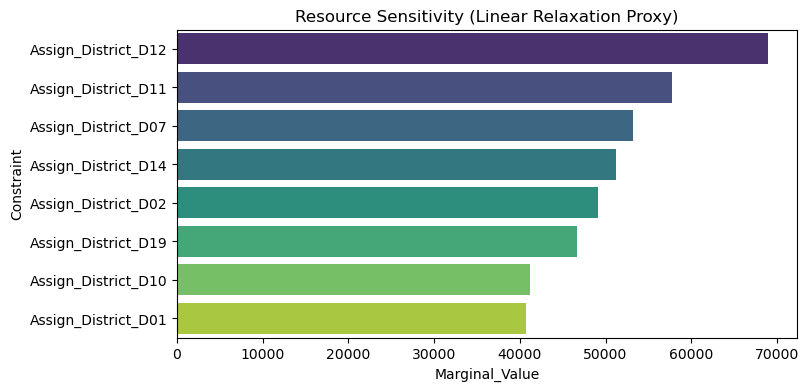


💾 结果已保存: EV_Station_Location_Solution.xlsx

📝 LaTeX 表格代码 (Top 10):
\begin{tabular}{lr}
\toprule
Variable & Value \\
\midrule
x_S01_D02 & 1.000000 \\
x_S01_D05 & 1.000000 \\
x_S01_D06 & 1.000000 \\
x_S01_D15 & 1.000000 \\
x_S02_D01 & 1.000000 \\
x_S02_D08 & 1.000000 \\
x_S02_D12 & 1.000000 \\
x_S02_D17 & 1.000000 \\
x_S03_D10 & 1.000000 \\
x_S03_D11 & 1.000000 \\
\bottomrule
\end{tabular}


📝 建议的论文方法论描述:

        \subsection{Integer Programming Formulation}
        We formulated the problem as a 0-1 Integer Programming (IP) model. 
        Decision variables $x_{ij}$ are binary, indicating selection. 
        Constraints include logical assignments and resource limits. 
        For mixed-logic conditions, the Big-M method was employed.
        Sensitivity analysis was conducted via Linear Relaxation to identify critical constraints.
        

🎨 === Phase 5: 选址策略可视化 ===
   - 正在绘制指派连线...


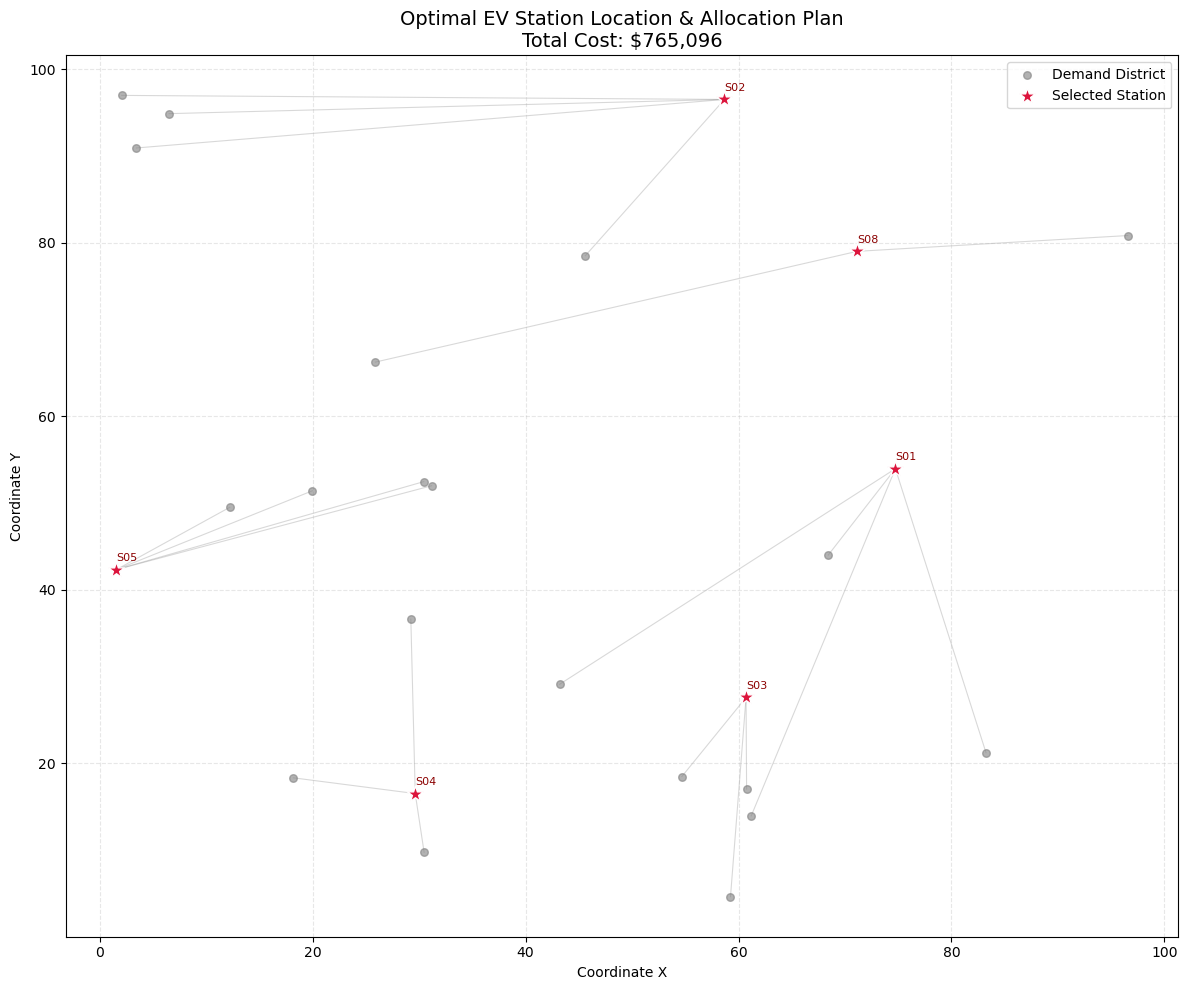

✅ 可视化图表已生成。


In [12]:
import matplotlib.pyplot as plt

# ==========================================
# Phase 4: 结果分析与导出
# ==========================================
print("\n📊 === Phase 4: 深度分析与交付 ===")

# 1. 灵敏度分析 (Sensitivity Analysis)
# 查看哪些站点的容量限制了更优解（Shadow Price 估算）
model.analyze_sensitivity()

# 2. 导出结果文件
model.export_results()

# 3. 打印方法论摘要 (用于论文写作)
print("\n📝 建议的论文方法论描述:")
print(model.get_methodology())

# ==========================================
# Phase 5: 核心可视化 (Visualization)
# ==========================================
print("\n🎨 === Phase 5: 选址策略可视化 ===")

def plot_solution(sites_df, districts_df, y_vars, x_vars):
    plt.figure(figsize=(12, 10))
    
    # --- 1. 数据准备 ---
    # 构建坐标字典以便快速查找: {ID: (x, y)}
    site_coords = dict(zip(sites_df['Site_ID'], zip(sites_df['X'], sites_df['Y'])))
    dist_coords = dict(zip(districts_df['District_ID'], zip(districts_df['X'], districts_df['Y'])))
    
    # --- 2. 绘制连线 (Assignments) ---
    # 遍历所有可能的连接，若 x[i][j]=1 则画线
    # 建议先画线，这样点会覆盖在线上，图层更整洁
    print("   - 正在绘制指派连线...")
    for i in site_coords.keys():
        for j in dist_coords.keys():
            # 检查变量值 (注意浮点数精度，使用 > 0.5 判断)
            if x_vars[i][j].varValue > 0.5:
                sx, sy = site_coords[i]
                dx, dy = dist_coords[j]
                plt.plot([sx, dx], [sy, dy], c='gray', alpha=0.3, linewidth=0.8, zorder=1)

    # --- 3. 绘制社区 (Districts) ---
    plt.scatter(
        districts_df['X'], districts_df['Y'], 
        c='gray', s=30, alpha=0.6, label='Demand District', zorder=2
    )
    
    # --- 4. 绘制站点 (Sites) ---
    # 分离被选中和未选中的站点
    selected_sites_x = []
    selected_sites_y = []
    
    # 遍历检查 y[i] 是否被选中
    for i in site_coords.keys():
        if y_vars[i].varValue > 0.5:
            selected_sites_x.append(site_coords[i][0])
            selected_sites_y.append(site_coords[i][1])
            
            # (可选) 标注选中的站点ID
            plt.text(site_coords[i][0], site_coords[i][1]+1, i, fontsize=8, color='darkred')

    # 绘制选中的站点 (红色大点)
    plt.scatter(
        selected_sites_x, selected_sites_y, 
        c='crimson', s=150, marker='*', label='Selected Station', zorder=3, edgecolors='white'
    )
    
    # (可选) 绘制未选中的站点 (空心圈，表示潜在位置)
    # unselected_mask = ~sites_df['Site_ID'].isin([i for i in site_coords if y_vars[i].varValue > 0.5])
    # unselected = sites_df[unselected_mask]
    # plt.scatter(unselected['X'], unselected['Y'], c='none', edgecolors='blue', s=50, alpha=0.3, label='Potential Site')

    # --- 5. 图表美化 ---
    plt.title(f'Optimal EV Station Location & Allocation Plan\nTotal Cost: ${pulp.value(model.prob.objective):,.0f}', fontsize=14)
    plt.xlabel('Coordinate X')
    plt.ylabel('Coordinate Y')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # 显示
    plt.show()
    print("✅ 可视化图表已生成。")

# 调用绘图函数
# 注意：传入原始 DataFrame 和模型中的变量字典
plot_solution(df_sites, df_districts, y, x)